In [1]:
import argparse
import math
import os
import pickle
import warnings

# from data_generation.data_generator import DataGenerator
import data_generator
from util.MT3DataConvertor import MT3DataConvertor
import PerformanceEval
import matplotlib.pyplot as plt
import numpy as np
import torch
from util.load_config_files import load_yaml_into_dotdict
from util.misc import super_load
import scipy.io as scio
import PerformanceEval

# from modules.loss import MotLoss
# from modules import evaluator

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [10]:
# Parse arguments and load the model, before doing anything else (important, reduces possibility of weird bugs)
parser = argparse.ArgumentParser()
# parser.add_argument('-rp', '--result_filepath', default='/home/weixinwei/study/MT3-test/src/results/2023-03-31_211406')
# parser.add_argument('-tp', '--task_params', default='/home/weixinwei/study/MT3-test/configs/tasks/scen2.5.yaml')
# parser.add_argument('-mp', '--model_params', default='/home/weixinwei/study/MT3-test/configs/models/mt3.pro.yaml')
parser.add_argument('-rp', '--result_filepath', default='/home/weixinwei/data/MT3/Results/2022-12-18_022739')
parser.add_argument('-tp', '--task_params', default='/home/weixinwei/data/MT3/Results/2022-12-18_022739/code_used/task_params.yaml')
parser.add_argument('-mp', '--model_params', default='/home/weixinwei/data/MT3/Results/2022-12-18_022739/code_used/model_params.yaml')
args = parser.parse_known_args()[0]
print(f'Evaluating results from folder: {args.result_filepath}...')

model, params = super_load(args.result_filepath, verbose=True)

# Test that the model was trained in the task chosen for evaluation
if args.task_params is not None:
    task_params = load_yaml_into_dotdict(args.task_params)
    for k, v in task_params.data_generation.items():
        if k not in params.data_generation:
            warnings.warn(f"Key '{k}' not found in trained model's hyperparameters")
        elif params.data_generation[k] != v:
            warnings.warn(f"Different values for key '{k}'. Task: {v}\tTrained: {params.data_generation[k]}")
    # Use task params, not the ones from the trained model
    params.recursive_update(task_params)  # note: parameters specified only on trained model will remain untouched
else:
    warnings.warn('Evaluation task was not specified; inferring it from the task specified in the results folder.')

# eval_params = load_yaml_into_dotdict('configs/eval/default.yaml')
eval_params = load_yaml_into_dotdict('/home/weixinwei/study/MT3-test/configs/eval/default.yaml')
params.recursive_update(eval_params)

# data_generator = DataGenerator(params)
# mt3DataConvertor = MT3DataConvertor(args.task_params, args.model_params, evalBS = 1, matPath='/home/weixinwei/Sensor.mat')
# mt3DataConvertor = MT3DataConvertor(args.task_params, args.model_params, evalBS = 1)
GetSeqBatch = data_generator.GetSeqBatch(params)
# GetSeqBatch = data_generator.GetWinBatch(params)
# mot_loss = MotLoss(params)

Evaluating results from folder: /home/weixinwei/data/MT3/Results/2022-12-18_022739...
[INFO]: Loading weights /home/weixinwei/data/MT3/Results/2022-12-18_022739/checkpoints/checkpoint_gradient_step_199999


In [27]:
batch, labels, unique_ids = next(GetSeqBatch)
# batch, labels, unique_ids = mt3DataConvertor.Get_batch()
output, _, _, _, _ = model.forward(batch, unique_ids)

In [3]:
x = PerformanceEval.SeqPredExport(mt3DataConvertor, model, 51, 5, 0.4)

In [4]:
trajectory = {'trajectory': x}

In [5]:
scio.savemat(f'/home/weixinwei/trajectory.mat', trajectory)

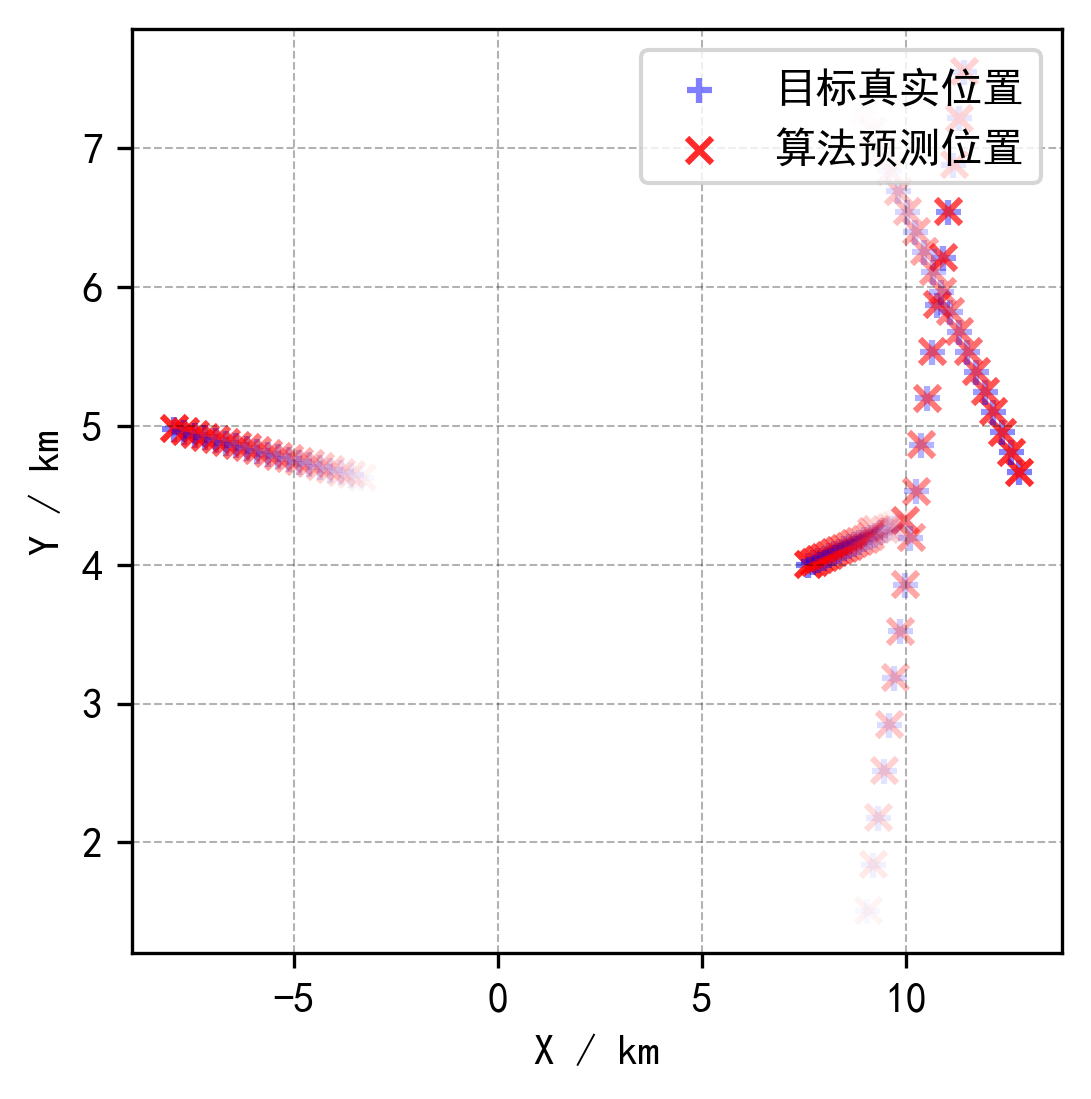

In [20]:
# xRMSE, yRMSE = PerformanceEval.CalculateRMSE(mt3DataConvertor, model, 31, 1, 1000, 5, 0.4)
SeqPredPlot(GetSeqBatch, model, 19, 0.4)

In [18]:
x = '11'
RMSE = {f'RMSE{x}':{'scene':f'{x}', 'xRMSE': xRMSE, 'yRMSE': yRMSE}}
scio.savemat(f'/home/weixinwei/ToMATLAB/RMSE{x}.mat', RMSE)

In [4]:
# GetSeqBatch = data_generator.GetSeqBatch(params)
# GetSeqBatch = data_generator.GetWinBatch(params)
# data_generator = DataGenerator(params)
data = scio.loadmat('/home/weixinwei/ToMATLAB/RMSE1.1.mat')

In [21]:
for i in range(1, 4):
	for j in range(1, 5):
		x = f'{i}.{j}'
		y = f'{i}_{j}'
		data = scio.loadmat(f'/home/weixinwei/ToMATLAB/RMSE{x}.mat')
		xRMSE = data[f'RMSE{x}']['xRMSE'][0, 0]
		yRMSE = data[f'RMSE{x}']['yRMSE'][0, 0]
		RMSE = {f'RMSE{y}':{'scene':f'{x}', 'xRMSE': xRMSE, 'yRMSE': yRMSE}}
		scio.savemat(f'/home/weixinwei/ToMATLAB/RMSE{y}.mat', RMSE)

In [17]:
xRMSE

array([[0.19729385],
       [0.19776133],
       [0.19846083],
       [0.19957559],
       [0.19997785],
       [0.19983462],
       [0.20047665],
       [0.20087636],
       [0.20144769],
       [0.20108335],
       [0.20117606],
       [0.2011775 ],
       [0.20159303],
       [0.20180186],
       [0.20155912],
       [0.20146073],
       [0.20128499],
       [0.20108393],
       [0.2013875 ],
       [0.20163824],
       [0.2017054 ],
       [0.20166064],
       [0.20165152],
       [0.20248142],
       [0.20384863],
       [0.20455888],
       [0.20472262],
       [0.205464  ],
       [0.26013808],
       [0.26127658],
       [0.21224016]])

In [ ]:
sensor = data['sensor']
radar = sensor[0,0]
radarTruth = radar[9]
state = np.zeros((0, 16, 2))
logit = np.zeros((0, 16))

def dataGen(timestep):
	batch, labels, unique_ids, _ = data_generator.get_batch()
	dt = 0.1
	transData = np.zeros((0, 3))
	for i in range(50):
		temp = radarTruth[i + timestep, 0].T
		temp[:, 2] = i * dt
		transData = np.vstack((transData, temp))
	#end
	transDataTensor = torch.tensor(transData, device='cuda:0', dtype=torch.float32)
	batch.tensors = torch.unsqueeze(transDataTensor, dim = 0)
	batch.mask = torch.unsqueeze(torch.zeros(transDataTensor.shape[0]).bool().cuda(device='cuda:0'), dim = 0)
	return batch, unique_ids

for i in range(50):
	batch, unique_ids = dataGen(i)
	output, _, _, _, _ = model.forward(batch, unique_ids)
	output_state = output['state'].detach().cpu().numpy()
	output_logits = output['logits'].sigmoid().detach().cpu().numpy()
	output_logits = np.squeeze(output_logits, axis=2)
	state = state = np.concatenate((state, output_state), axis=0)
	logit = np.concatenate((logit, output_logits), axis=0)
	

In [ ]:
toMat = {'state': state, 'logit': logit}
scio.savemat('output.mat', toMat)

In [ ]:
# batch, labels, unique_ids, trajectories = data_generator.get_radar_batch(0.5, 1)
batch, labels, unique_ids = data_generator.get_polar_batch()
plt.figure(figsize=(8, 8), dpi=300)

# falseMeas = batch.tensors[0][(unique_ids[0] == -1)].cpu()
# plt.scatter(falseMeas.T[0], falseMeas.T[1], color='k', marker='.', alpha=falseMeas.T[2]/winSize/1.2, label='False Measurements')

output, memory, contrastive_classifications, queries, attn_maps = model.forward(batch, unique_ids)
PlotResult(batch, labels, output)


In [19]:
# torch.pow(min([torch.Tensor([3]), 2]), 2)
mt3DataConvertor.ResetBias()

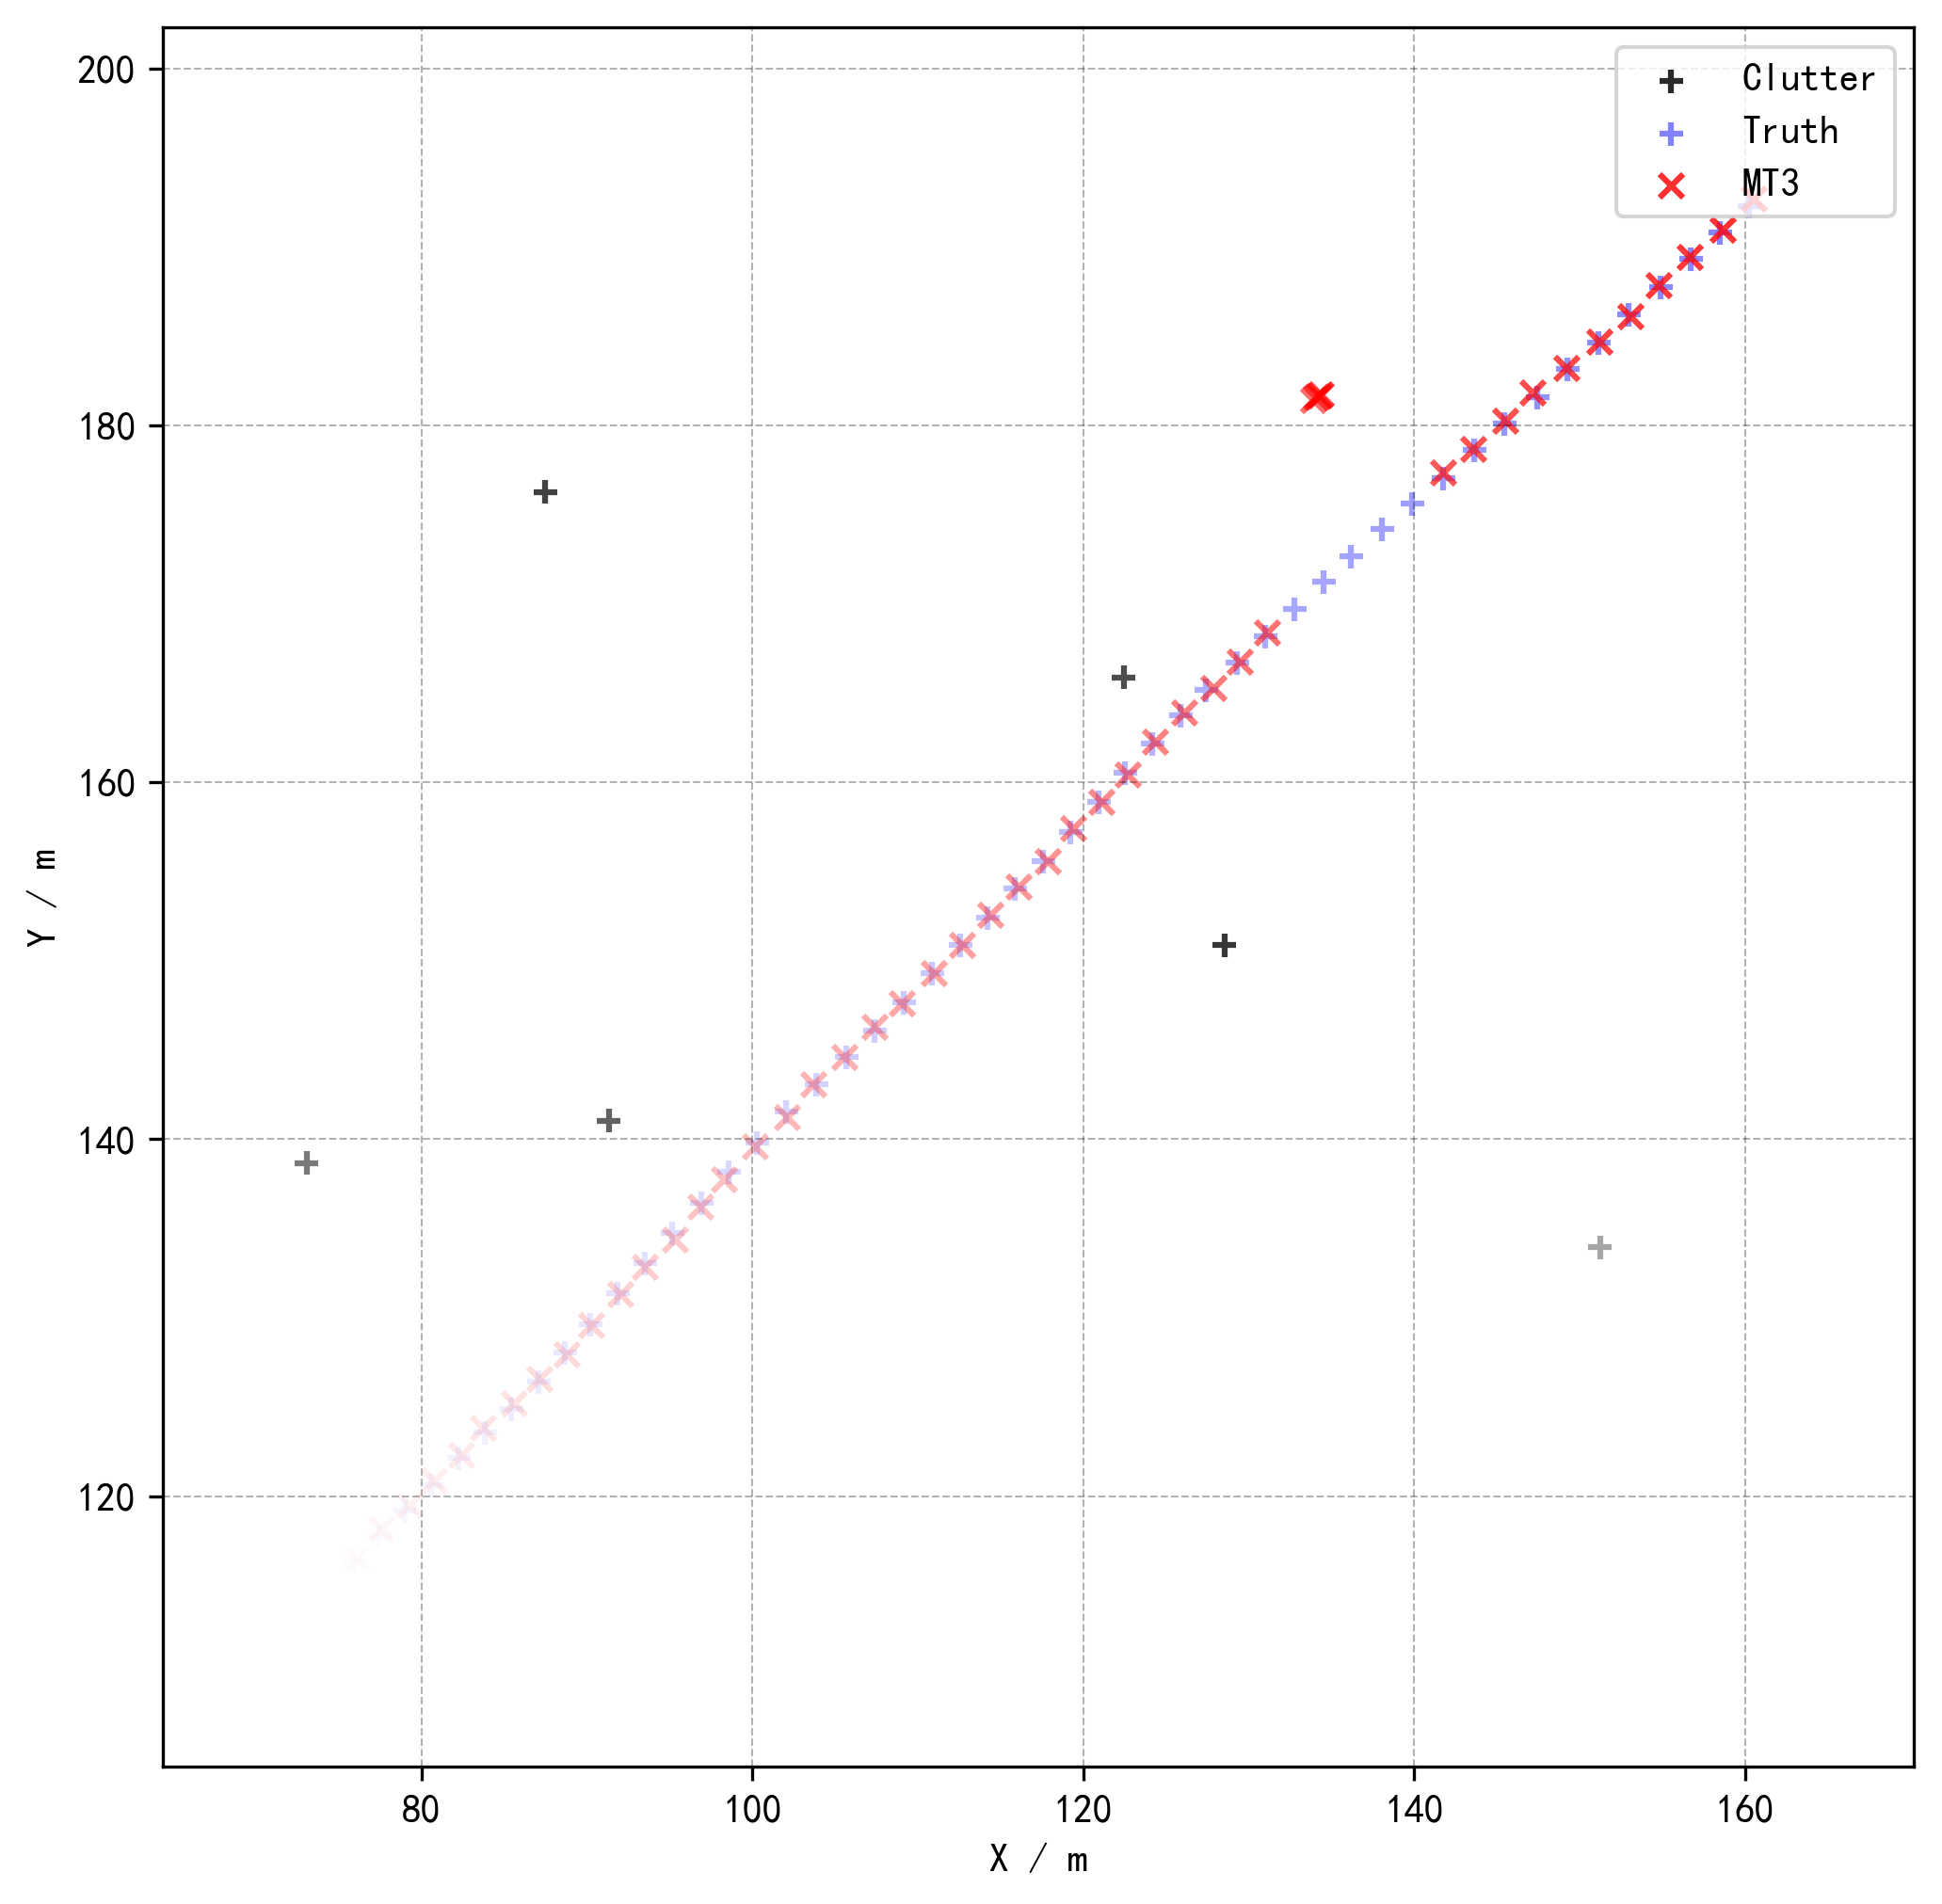

In [29]:
SeqPredPlot(mt3DataConvertor, model, 51, 0.4)
# xRMSE, yRMSE = CalculateRMSE(mt3DataConvertor, model, 31, 1, 100, 5, 0.4)

In [ ]:
def CalculateRMSE(dataGenerator, model, cycle, batchSize, times, cutoffDistance, existanceThreshold = 0.9):
# dataGenerator = mt3DataConvertor
# cycle = 31
# batchSize = 1
# times = 10
# cutoffDistance = 50
# existanceThreshold = 0.4
	nTimes = 0
	xRMSE = np.zeros([cycle, batchSize])
	yRMSE = np.zeros([cycle, batchSize])
	while nTimes < times:
		mt3DataConvertor.ResetBias()
		for nCycle in range(cycle):
			batch, labels, unique_ids = dataGenerator.Get_batch()
			if nCycle == 0 and np.size(mt3DataConvertor.fusionData[0]['Radar']['Z_Truth'][50]) == 0:
				nTimes -= 1
				break
			output, _, _, _, _ = model.forward(batch, unique_ids)
			output_state = output['state'].detach()
			output_logits = output['logits'].sigmoid().detach()
			# bs, num_queries = output_state.shape[:2]
			
			for batchID in range(batchSize):
				# alive_idx = output_logits[batchID, :].squeeze(-1) > existanceThreshold
				maxThreshold = max([torch.max(output_logits[batchID, :].squeeze(-1)), existanceThreshold])
				alive_idx = output_logits[batchID, :].squeeze(-1) == maxThreshold
				alive_output = output_state[batchID, alive_idx, :].cpu().numpy() 	# Pred
				current_targets = labels[batchID].cpu().numpy()						# Truth

				if np.size(alive_output) == 0:
					xDiff = yDiff = cutoffDistance**2
				else:
					xDiff = min((alive_output[0, 0] - current_targets[0, 0])**2, cutoffDistance**2)
					yDiff = min((alive_output[0, 1] - current_targets[0, 1])**2, cutoffDistance**2)
				# end if
				xRMSE[nCycle, batchID] += xDiff
				yRMSE[nCycle, batchID] += yDiff
			# end for
		# end for
		nTimes += 1
	# end while
	xRMSE = np.sqrt(xRMSE/times)
	yRMSE = np.sqrt(yRMSE/times)
	return xRMSE, yRMSE

In [ ]:
mt3DataConvertor.fusionData[0]['Radar']['Z_Truth'][50]

In [14]:
falseMeas.shape[0] != 0

False

[1, 2]

In [19]:
def SeqPredPlot(dataGenerator, model, timeStep, existanceThreshold = 0.9):
	'''
	序列化预测结果绘制
	'''
# dataGenerator = GetSeqBatch
# timeStep = 19
# existanceThreshold = 0.4

	plt.figure(figsize=(4, 4), dpi=300)
	plt.rcParams['font.sans-serif'] = ['SimHei']
	plt.rcParams['axes.unicode_minus'] = False
	xLim = []; yLim = []
	for stepID in range(timeStep):
		batch, labels, unique_ids = next(dataGenerator)
		# batch, labels, unique_ids = dataGenerator.Get_batch()
		output, _, _, _, _ = model.forward(batch, unique_ids)
		output_state = output['state'].detach()
		output_logits = output['logits'].sigmoid().detach()
		bs, num_queries = output_state.shape[:2]
		for batchID in range(bs):
			if stepID == 0:
				falseMeas = batch.tensors[batchID][(unique_ids[batchID] == -1)].cpu()
				if falseMeas.shape[0] != 0:
					plt.scatter(falseMeas.T[0][:-1], falseMeas.T[1][:-1], color='k', marker='+', alpha=falseMeas.T[2][:-1]/falseMeas.T[2].max()/1.2)
					plt.scatter(falseMeas.T[0][-1], falseMeas.T[1][-1], color='k', marker='+', alpha=1/1.2, label='Clutter')
				# end if
			# end if
			alive_idx = output_logits[batchID, :].squeeze(-1) > existanceThreshold
			# maxThreshold = max([torch.max(output_logits[batchID, :].squeeze(-1)), existanceThreshold])
			# alive_idx = output_logits[batchID, :].squeeze(-1) == maxThreshold
			alive_output = output_state[batchID, alive_idx, :].cpu()
			current_targets = labels[batchID].cpu()
			pointAlpha = 1 - stepID / timeStep
			# pointAlpha = stepID / timeStep
			# if stepID == timeStep - 1 and batchID == 0:
			if stepID == 0 and batchID == 0:
				plt.scatter(current_targets.T[0], current_targets.T[1], color='b', marker='+', alpha=pointAlpha/2, label = '目标真实位置')
				plt.scatter(alive_output.T[0], alive_output.T[1], color='r', marker='x', alpha=pointAlpha/1.2, label = '算法预测位置')
			else:
				plt.scatter(current_targets.T[0], current_targets.T[1], color='b', marker='+', alpha=pointAlpha/2)
				plt.scatter(alive_output.T[0], alive_output.T[1], color='r', marker='x', alpha=pointAlpha/1.2)
			# end if
			if stepID == 0 or stepID == timeStep - 1:
				xLim.append(current_targets.T[0])
				yLim.append(current_targets.T[1])
			# end if
		# end for
	# end for
	# xLim.sort(); yLim.sort()
	# plt.xlim((xLim[0]-10, xLim[1]+10))
	# plt.ylim((yLim[0]-10, yLim[1]+10))
	plt.xlabel('X / km')
	plt.ylabel('Y / km')
	plt.legend(loc = 1)
	plt.grid(True, linestyle="--", color="k", linewidth=0.5, alpha=0.3)
	plt.show()

# SeqPredPlot(mt3DataConvertor, model, 31, 0.4)
# SeqPredPlot(GetSeqBatch, model, 19, 0.1)

In [ ]:
def PlotResult(batch, labels, output):
	'''
	训练数据绘制
	'''
	outputs = output
	targets = labels
	existance_threshold = 0.8

	output_state = outputs['state'].detach()
	output_logits = outputs['logits'].sigmoid().detach()
	bs, num_queries = output_state.shape[:2]

	# plt.subplot(5, 4, pnum)

	colorEnum = ['r', 'y', 'g', 'c', 'b', 'm', 'r', 'y', 'g', 'c', 'b', 'm']
	for measBatch in range(bs):
		measPosX = batch.tensors[measBatch, ~batch.mask[measBatch], 0].cpu()
		measPosY = batch.tensors[measBatch, ~batch.mask[measBatch], 1].cpu()
		measAlph = (batch.tensors[measBatch, ~batch.mask[measBatch], 2]/max(batch.tensors[measBatch, ~batch.mask[measBatch], 2])/2).cpu()
		# measAlph = 1 - fnum/19
		
		alive_idx = output_logits[measBatch, :].squeeze(-1) > existance_threshold
		alive_output = output_state[measBatch, alive_idx, :].cpu()
		current_targets = targets[measBatch].cpu()

		# plt.figure(figsize=(8, 8), dpi=300)
		# # 笛卡尔
		plt.scatter(measPosX, measPosY, color='k', marker='+', alpha=measAlph)
		plt.scatter(current_targets.T[0], current_targets.T[1], color='b', marker='+', alpha=0.5, label = 'Ground Truth')
		plt.scatter(alive_output.T[0], alive_output.T[1], color='r', marker='x', alpha=0.5, label = 'MT3 Prediction')

		# 极坐标
		# ax = plt.axes(projection='polar')
		# ax.scatter(measPosY*np.pi/180.0, measPosX, color='k', marker='+', alpha=measAlph)
		# ax.scatter(current_targets.T[1]*np.pi/180.0, current_targets.T[0], color='b', marker='+', alpha=0.5, label = 'Ground Truth')
		# ax.scatter(alive_output.T[1]*np.pi/180.0, alive_output.T[0], color='r', marker='x', alpha=0.5, label = 'MT3 Prediction')

		# for targetNo in list(trajectories[measBatch]):
		# 	trackPosX = trajectories[measBatch][targetNo].T[0]
		# 	trackPosY = trajectories[measBatch][targetNo].T[1]
		# 	trackAlph = trajectories[measBatch][targetNo].T[4]/max(trajectories[measBatch][targetNo].T[4])
		# 	plt.scatter(trackPosX, trackPosY, color=colorEnum[targetNo], marker='x', alpha=trackAlph)

		# 笛卡尔
		# plt.xlim((-100, 100))
		# plt.ylim((-100, 100))
		plt.grid(True, linestyle="--", color="k", linewidth=0.5, alpha=0.3)
		plt.legend(loc=1, frameon=True, fontsize = 8)
		plt.xlabel('Range / m')
		plt.ylabel('Angle / °')
		# 极坐标
		# ax.set_thetagrids(np.arange(-90.0, 90.0, 10.0))
		# # ax.set_rgrids(np.arange(0, 100, 10))
		# ax.grid(True, linestyle="--", color="k", linewidth=0.5, alpha=0.3)
		# ax.set_axisbelow('True')
		# plt.legend(loc=1, frameon=True)
		# plt.xlim((-np.pi/2, np.pi/2))
		# # plt.ylim((0, 100))

		plt.show()